# Spatio-Temporal Data | Analysis

# 0 Imports

The following packages will be needed for this notebook.

In [ ]:
# Imports for the whole notebook:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import json
import contextily as ctx
import mplleaflet
#%matplotlib notebook
from matplotlib import pyplot as plt
from IPython.display import display
from h3 import h3
from shapely.ops import cascaded_union
from shapely.geometry import mapping
from IPython.display import YouTubeVideo, Image
from shapely_geojson import dumps
from shapely import geometry
import warnings
warnings.filterwarnings('ignore')
# Fix for ssl certificate
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
%%html
<style>
table {float:left}
</style>
<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-cly1{text-align:left;vertical-align:middle}
.tg .tg-7fle{font-weight:bold;background-color:#efefef;text-align:center;vertical-align:top}
.tg .tg-ncfi{font-weight:bold;background-color:#efefef;text-align:center;vertical-align:middle}
.tg .tg-cyhs{font-weight:bold;background-color:#efefef;text-align:left;vertical-align:middle}
.tg .tg-hpm8{font-weight:bold;background-color:#f8a102;border-color:#333333;text-align:center;vertical-align:middle}
.tg .tg-0lax{text-align:left;vertical-align:top}
</style>

# 1 Introduction

In this notebook we will take a closer look on how to distinguish different categories of spatio-temporal data and how to anlayse, discretize and visualize them.

This notebook makes use of `pandas` and `geopandas` - libraries you already know. As a reminder, the official documentation can be found here: 
* https://pandas.pydata.org/docs/
* https://geopandas.org/index.html

# 2 Spatio-temporal discretization

For a number of analyses, a discretization is necessary or desirable in order to obtain a better overview of the data or to enable a meaningful categorization and visualization. In the following, temporal, spatial and spatial-temporal discretizations are examined and explained in more detail.

We will use the pickup carsharing dataset which you already know from the previous notebook. This dataset belong to the category of spatio-temporal data which has the highest practical and theoretical complexity. At the same time, these types of data also offer many potentials, since a large number of real processes - especially in mobility analysis - are dependent on place and time (e.g., it can be assumed that a larger number of people are present in industrial estates during typical working hours than outside this time at the same place).

In [3]:
# Read carshating dataset
df_fleet = pd.read_csv('data/carsharing.csv', parse_dates=['StartTime', 'DestinationTime'])

# Load Pickups into GeoDataFrame
gdf_pickups = gpd.GeoDataFrame(crs='epsg:4326', geometry=gpd.points_from_xy(df_fleet.StartLongitude, df_fleet.StartLatitude))
gdf_pickups.index = df_fleet.StartTime
gdf_pickups.head()

,geometry
StartTime,
2019-07-01 00:03:04,POINT (11.55432 48.12092)
2019-07-01 00:03:04,POINT (11.53352 48.15513)
2019-07-01 00:03:04,POINT (11.56246 48.16635)
2019-07-01 00:13:04,POINT (11.57004 48.12679)
2019-07-01 00:03:04,POINT (11.55634 48.13917)


## Temporal discretization

![temporal_discretization_I.png](data/img/temporal_discretization_I.png)
![temporal_discretization_II.png](data/img/temporal_discretization_II.png)
![temporal_discretization_III.png](data/img/temporal_discretization_III.png)

**What is to be considered?**

- If you begin your time periods with the first data point, the last time period may contain considerably less observations than the others and vice versa.
- Many common time units do not always have the same length! Days, months and years vary in length (time change, 30/31 days, leap year).
- The conversion factor between time units is usually not a multiple of 10
...

### Discretization/resampling the data

A common way to resample time series data in pandas is the `pandas.DataFrame.resample` method.   
* https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html  
* http://benalexkeen.com/resampling-time-series-data-with-pandas/

You can choose different resampling options in combination with aggregation functions:

**Resampling Options:**

| Alias  | Description           | Alias  | Description           |
|:-------|:----------------------|:-------|:----------------------|
| A      | Year end              | M      | Month end             |
| AS     | Year start            | N, ns  | Nanosecond frequency  |
| B      | Business day          | Q      | Quarter end           |
| BA     | Business year end     | S      | Secondly frequency    |
| D      | Calendar day          | T, min | Minutely frequency    |
| H      | Hourly frequency      | U, us  | Microsecond frequency |
| L, ms  | Millisecond frequency | W      | Weekly                |

**Aggregation Functions:**

| Method  | Description                                               | Method  | Description                                               |
|:--------|:----------------------------------------------------------|:--------|:----------------------------------------------------------|
| bfill   | Backward fill                                             | min     | Minimum data value                                        |
| count   | Count of values                                           | nunique | Number of unique values                                   |
| ffill   | Forward fill                                              | ohlc    | Opening value, highest value, lowest value, closing value |
| first   | First valid data value                                    | pad     | Same as forward fill                                      |
| last    | Last valid data value                                     | std     | Standard deviation of values                              |
| max     | Maximum data value                                        | sum     | Sum of values                                             |
| mean    | Mean of values in time range                              | var     | Variance of values                                        |
| median  | Median of values in time range                            |

**Downsampling Example**

If your data is recorded with high frequency or if you want to compare datasets with different sampling frequency, it might be helpfull to downsample your available data, e.g., to a frequency of '1H' and then count the number of entries.

StartTime
2019-07-01 00:00:00    58
2019-07-01 01:00:00    36
2019-07-01 02:00:00    23
2019-07-01 03:00:00    23
2019-07-01 04:00:00    65
Freq: H, Name: geometry, dtype: int64

StartTime
2019-07-01    2526
2019-07-02    2762
2019-07-03    2787
2019-07-04    2764
2019-07-05    3138
Freq: D, Name: geometry, dtype: int64

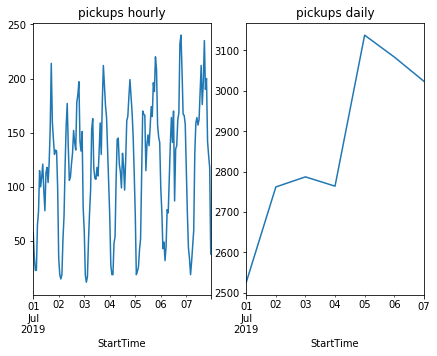

In [4]:
# Sample time series with hourly frequency and count the number of 'geometry' entries
pickups_hourly = gdf_pickups.geometry.resample('1H').count()
# Sample time series with daily frequency and count the number of 'geometry' entries
pickups_daily = gdf_pickups.geometry.resample('1D').count()

# Look at the data
display(pickups_hourly.head(), pickups_daily.head())

# Plot time series
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(7,5))
pickups_hourly.plot(ax = ax1, title='pickups hourly')
pickups_daily.plot(ax = ax2, title='pickups daily')
plt.show()

## Spatial discretization/indexing

A second way to discretise our dataset is spatial discretization. As we did it when applying temproal discretisation, we split our dataset into spatial subsets. Basically there are two common approaches: The first one uses regular grids, to devide our data into evenly distributed shapes, like rectangles, triangles or hexagons. The second one uses contextual shapes, like counties, city districts and so on.

### Regular grids
Aplying regular grids to a dataset is very easy. There are three different ways to split a 2D surface into smaller shapes:


Triangles                  |Squares/Rectangels         |Hexagons                   |
:-------------------------:|:-------------------------:|:-------------------------:|
![](https://1fykyq3mdn5r21tpna3wkdyi-wpengine.netdna-ssl.com/wp-content/uploads/2018/06/image2-2-300x231.png)   |![](https://1fykyq3mdn5r21tpna3wkdyi-wpengine.netdna-ssl.com/wp-content/uploads/2018/06/image25-1-300x231.png)  |![](https://1fykyq3mdn5r21tpna3wkdyi-wpengine.netdna-ssl.com/wp-content/uploads/2018/06/image22-300x231.png)

*(Images from https://eng.uber.com/h3/)*


**Pros:**
* Easy calculations for mapping of data points
* Hierachical structure through splitting
* Equal shapes with equal sizes

**Cons:**
* Multiple types of neighbors for triangles and squares
* Shapes may not be equal over the whole earth surface (depending on projection etc.)


#### Popular geoindex libraries:
Luckily, there are a bunch of open-source libraries, that make our lives easier when it comes to spatial data analysis:

| System  | Index representation | Cell shape | Projection system                      |
|:--------|:---------------------|:-----------|:---------------------------------------|
| [H3](https://uber.github.io/h3/)      | 64 bit integer       | hexagon    | Icosahedron face centered gnomonic     |
| [S2](https://docs.google.com/presentation/d/1Hl4KapfAENAOf4gv-pSngKwvS_jwNVHRPZTTDzXXn6Q/edit)      | 64 bit integer       | rectangle  | Cube face centered quadratic transform |
| [Geohash](https://en.wikipedia.org/wiki/Geohash) | alphanumeric string  | rectangle  | None, encodes latitude and longitude   |  

*Source: https://uber.github.io/h3/#/documentation/overview/use-cases*

### Contextual shapes
Deviding your data into contextual shapes may be usefull, if you have other data sources which are based on those units. For example if you want to compare your dataset against a population dataset from a census survey, it may be helpful to split your dataset also into the same districts that where used in the census survey.

http://opendatalab.de/ offers for example shapes for all counties, and cities in Germany as `geojson` files.\
An other source could be http://www.opensreetmap.org.

**Pros:**
* Easy to join with other datasources like socio-demographic data 
* Shapes represent a spatial context

**Cons:**
* Shapes have different sizes
* Complex calulations to map points into the shapes

## H3 Example
### About H3
<img src="https://1fykyq3mdn5r21tpna3wkdyi-wpengine.netdna-ssl.com/wp-content/uploads/2018/06/image12.png" width="240" align="left"/>

>The H3 geospatial indexing system is a discrete global grid system (see Sahr et al., 2003) consisting of a multi-precision hexagonal tiling of the sphere with hierarchical indexes. The hexagonal grid system is created on the planar faces of a sphere-circumscribed icosahedron, and the grid cells are then projected to the surface of the sphere using an inverse face-centered polyhedral gnomonic projection.

**Official Documentation**
* https://uber.github.io/h3/#/
* https://github.com/uber/h3-py
* https://github.com/uber/h3-py-notebooks

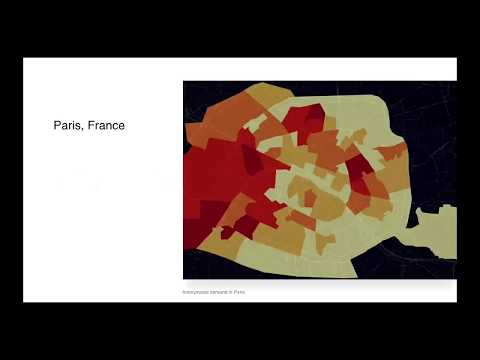

In [5]:
YouTubeVideo(id='ay2uwtRO3QE')

### Generate a grid for the city-area of munich

Lets see how Munich can be separated in hexagons. For this example we use a h3 resolution of 8. Feel free to play around with different resolutions. Unfortunateley h3's python bindings do not support `geopandas` or `shapely` objects but `geoJSON` so far. Thus we need to get the city boundary of munich as `geoJSON` first. We can get it for example from http://opendatalab.de/projects/geojson-utilities/. 

Let's see what we've got:

In [6]:
# Load munich-boundary geoJSON in a geoDataFrame 
gdf_munich_boundary = gpd.read_file('data/munich-boundary.geojson')

# Plot the city-boundary using mplleaflet
fig, ax = plt.subplots(1)
fig.set_size_inches(10,7)
gdf_munich_boundary.to_crs(epsg=4326).plot(ax = ax, alpha= 0.3, edgecolor='black')
mplleaflet.display(fig=fig)

**Generating h3 cells**

The h3 cells are automatically obtained by filling the city boundary of Munich with hexagons of desired h3 resolution. This process subsist of several steps that are explained in the **appendix notebook**. For the sake of simplicity, we load a previously generated 'geoJSON' object that contains the calculated shapes of the h3 hexagons generated for the city of Munich (h3_resolution=8). The result is visualized in the following.

In [15]:
gdf_munich_h3 = gpd.read_file('data/gdf_munich_h3.geojson')

# Important: When reloading the dataset we need to set 'h3_index' as index again and we can drop the 'h3_index' column!
gdf_munich_h3.index = gdf_munich_h3.h3_index
gdf_munich_h3 = gdf_munich_h3.drop(columns='h3_index')

display(gdf_munich_h3.head())

# Plot the city-boundary using mplleaflet
fig, ax = plt.subplots(1)
fig.set_size_inches(10,7)
gdf_munich_h3.to_crs(epsg=4326).plot(ax = ax, alpha= 0.3, edgecolor='black')
mplleaflet.display(fig=fig)

,geometry
h3_index,
881f8d45edfffff,"POLYGON ((11.46585 48.12723, 11.46390 48.12272..."
881f8d7a65fffff,"POLYGON ((11.55297 48.10782, 11.55102 48.10331..."
881f8d7107fffff,"POLYGON ((11.66058 48.15006, 11.65862 48.14555..."
881f8d473dfffff,"POLYGON ((11.41134 48.17788, 11.40939 48.17337..."
881f8d44a7fffff,"POLYGON ((11.56165 48.14249, 11.55969 48.13798..."


# 3 Carsharing spatial analysis
Let's use this h3 grid of Munich for a carshing analysis: We want to identify the cell with the highest amount of car pickups. To achieve this we must determine the matching h3 index for every pickup. We can use `h3.geo_to_h3` to get h3 indexes from `lat/lng` pairs.

In [8]:
# Let's remember how our DataFrame of the pickup carsharing dataset looks like
print('Before:')
display(gdf_pickups.head())

# H3 works with WGS84 coordinates, therefore we need transform our GeoDataFrame
gdf_pickups = gdf_pickups.to_crs(epsg=4326)

# Apply the h3.geo_to_h3() func to our dataset to get the h3_index of each datapoint.
# This can be done be using a lambda function to map shapely x, y values to lat lng
gdf_pickups['h3_index'] = gdf_pickups.geometry.apply(lambda point: h3.geo_to_h3(lat=point.y, lng=point.x, res=8))

print('After:')
display(gdf_pickups.head())

Before:


,geometry
StartTime,
2019-07-01 00:03:04,POINT (11.55432 48.12092)
2019-07-01 00:03:04,POINT (11.53352 48.15513)
2019-07-01 00:03:04,POINT (11.56246 48.16635)
2019-07-01 00:13:04,POINT (11.57004 48.12679)
2019-07-01 00:03:04,POINT (11.55634 48.13917)


After:


,geometry,h3_index
StartTime,,
2019-07-01 00:03:04,POINT (11.55432 48.12092),881f8d4597fffff
2019-07-01 00:03:04,POINT (11.53352 48.15513),881f8d44e5fffff
2019-07-01 00:03:04,POINT (11.56246 48.16635),881f8d448dfffff
2019-07-01 00:13:04,POINT (11.57004 48.12679),881f8d7a45fffff
2019-07-01 00:03:04,POINT (11.55634 48.13917),881f8d44a5fffff


Now let's count pickups for each cell:

In [9]:
# Create a new DataFrame
df_h3_pickups_count = pd.DataFrame()

# Group pickups by h3_index and count them 
df_h3_pickups_count = gdf_pickups.groupby('h3_index').count()

# Rename columns
df_h3_pickups_count.columns = ['count']

# Display results
display(df_h3_pickups_count.head())

,count
h3_index,
881f88a9a5fffff,1
881f8d0821fffff,9
881f8d0825fffff,6
881f8d0827fffff,1
881f8d091dfffff,42


To visualize the results, we have to join counts with h3 geometries, we generated previously. 

In [10]:
# Join counts with munich h3 cells. Use a left join to keep indexes without counts
gdf_munich_h3_merged = gdf_munich_h3.join(df_h3_pickups_count, how='left')

# Fill NAN values with zeros 
gdf_munich_h3_merged['count'] = gdf_munich_h3_merged['count'].fillna(0)

# Sort DataFrame by counts
gdf_munich_h3_merged = gdf_munich_h3_merged.sort_values(by=['count'], ascending=False)

# Let's see what we've got:
display(gdf_munich_h3_merged.head())

# Plot the results 
fig, ax = plt.subplots(1)
fig.set_size_inches(10,7)
gdf_munich_h3_merged.to_crs(epsg=4326).plot(ax=ax, column='count', cmap='cividis', alpha=0.7)
mplleaflet.display(fig=fig)

,geometry,count
h3_index,,
881f8d4485fffff,"POLYGON ((11.56445 48.16362, 11.56249 48.15911...",368.0
881f8d44abfffff,"POLYGON ((11.56752 48.15602, 11.56556 48.15151...",347.0
881f8d44a3fffff,"POLYGON ((11.57059 48.14841, 11.56863 48.14390...",339.0
881f8d4487fffff,"POLYGON ((11.57647 48.16193, 11.57451 48.15742...",338.0
881f8d44a7fffff,"POLYGON ((11.56165 48.14249, 11.55969 48.13798...",314.0


### Carsharing spatio-temporal analysis
Finally let's combine spatial and temporal discretization: To do this we will use `pandas.MultiIndex` (https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html) and `groupby` aggregate functions.

In [17]:
# Create a copy of our pickups DataFrame
gdf_pickups_spatio_temporal = gdf_pickups.copy()

#  Resample the data hourly and group it based on h3_index.
gdf_pickups_spatio_temporal = gdf_pickups_spatio_temporal.groupby('h3_index').resample('1H').count()

# Let's see what we've got:
gdf_pickups_spatio_temporal.head()

geometry  h3_index
h3_index        StartTime                              
881f88a9a5fffff 2019-07-01 18:00:00         1         1
881f8d0821fffff 2019-07-01 14:00:00         1         1
                2019-07-01 15:00:00         0         0
                2019-07-01 16:00:00         0         0
                2019-07-01 17:00:00         0         0

We have now a `(Geo)DataFrame` with a `MuliIndex` on `h3_index` and `StartTime`. If we want, for example, to have a look at the hourly distribution of carsharing pickups in Munich between 6am and 12am, we can use this `MultiIndex` to count the number of pickups over cells and time.

In [18]:
# Slice all entries between 9am and 12am
pickups_between_6_and_12 = gdf_pickups_spatio_temporal[
    (gdf_pickups_spatio_temporal.index.get_level_values('StartTime').hour > 9) & 
    (gdf_pickups_spatio_temporal.index.get_level_values('StartTime').hour < 12)].copy()

# Drop and rename columns
pickups_between_6_and_12.drop(columns=['h3_index'], inplace= True)
pickups_between_6_and_12.columns = ['count']

# Group by h3_index
pickups_between_6_and_12 = pickups_between_6_and_12.groupby('h3_index').sum()

# Let's se what we've got:
pickups_between_6_and_12.head(10)

,count
h3_index,
881f8d0821fffff,0
881f8d0825fffff,1
881f8d091dfffff,7
881f8d0993fffff,2
881f8d099bfffff,0
881f8d09abfffff,0
881f8d09b9fffff,24
881f8d0f1bfffff,0
881f8d4411fffff,12


In [19]:
# Join counts with munich h3 cells. Use a left join to keep indexes without counts
pickups_between_6_and_12 = gdf_munich_h3.join(pickups_between_6_and_12, how='left')

# Fill NAN values with zeros 
pickups_between_6_and_12['count'] = pickups_between_6_and_12['count'].fillna(0)

# Plot the results 
fig, ax = plt.subplots(1)
fig.set_size_inches(10,8)
pickups_between_6_and_12.to_crs(epsg=4326).plot(ax=ax,column='count', cmap='cividis', alpha = 0.7)
mplleaflet.display(fig=fig)

# 4. Excercise: Analysing a Spatial Dataset - Food Places

## Task Description

Imagine that you have recently moved to Munich and you need to find a new appartment. As your cooking skills are pretty bad, it is important for you to have many food places near to your new neighboorhood. Some of your friends suggest that you should look for an appartment in Maxvorstadt, some others say that there are many food places in Giesing. As you are an engineer with interest in data science, you get the fantastic idea to download an public dataset that contains all food places in Munich.

You want to start your analysis by using h_3 hexagons to slice the city area into small areas and then count the number of food places of each h_3 cell. In which district will you instruct your real estate manager to look for an apartment for you?

PS: You are very lucky that you are the youngest offspring of a rich family and do not have to worry about crazy rents in Munich and your only decision criterion is a high density of food places ;)

You can use the following function to make reversing the lat and lon columns of DataFrames easier.

In [ ]:
# Reverse the lat and lon columns of a DataFrame
def reverse_lat_lon(hex_coords):
    geom_hex = []
    for lat_lon in hex_coords:
        geom_hex.append([lat_lon[1],lat_lon[0]])
    return geom_hex

## Your Task

1. Load the food_places_munich data and have a look at the data.
2. Asses the according h3_index to every food place in your dataset and add a new column for h3_index.
3. Aggreagte the number of amenities for each h3_celll into a new DataFrame indexed by h3_index. 
4. Plot a choroplete map with h3 cells, color coded with the numer of amenities per sqkm.
5. In which district are the most amenities located?

### 1. Load Data

In [ ]:
# This is the source of the food places dataset
file_food_places = "data/food_places_munich.geojson"

# Load the file into a GeoDataFrame and look at the data. Keep in mind to set the correct coordinate system 'epsg:4326'.
gdf_food_places = None # Load the file here
# INSERT CODE HERE | BEGIN
#<<solution>>
gdf_food_places = gpd.read_file(file_food_places, crs='epsg:4326')
display(gdf_food_places.head())
#<</solution>>
# INSERT CODE HERE | END

### 2./3. Count and Aggregate Food Places
For the next step, we want to count the number of food places according to their h3_index. This will allow ous to identify districts with higher density of amenties.

In [ ]:
# We choose the h3_resolution to get bins with an area close to 5 sqkm
h3_res = 7

# Based on the 'lng, lat' coordinates of our dataset, we want to calculate the corresponding h3_index and 
# add it to a new 'h3_index' column.
# Hint: The h3.geo_to_h3(lat, lng, res) function can be used to obtain the h3_index from coordinates. Use 
# DataFrame.apply(lat, lng, res) to apply a lambda fuction using the h3.geo_to_h3() function.
gdf_food_places['h3_index'] = None
# INSERT CODE HERE | BEGIN
#<<solution>>
gdf_food_places['h3_index'] = gdf_food_places.geometry.apply(lambda point: h3.geo_to_h3(lat=point.y, lng=point.x, res=h3_res))
#<</solution>>
# INSERT CODE HERE | ENDE

# Copy the dataset into a new dataset and group the dataset by the 'h3_index' and aggregating by the count of amenities.
# Hint: Use the GeoDataFrame.groupby() and GeoDataFrame.agg({'amenity':'count'}) functions.
df_food_places_agg = None
# INSERT CODE HERE | BEGIN
#<<solution>>
df_food_places_agg = gdf_food_places.groupby(['h3_index']).agg({'amenity':'count'})
df_food_places_agg.head()
#<<solution>>
# INSERT CODE HERE | ENDE

### 4. Visualization

As we want to visualize the our results later, we need to obtain geometry data to plot the h3 hexagons and to describe the boundary of the area. A helpful function to calculate the geo boundary based on a h3 index is `h3.h3_to_geo_boundary`. Before we can plot the obtain geometry data, we need to transform the geometry to shapely polygons by using `geometry.Polygon`. It is important to mention that we need to rearrange the list returned by h3 to `[lon,lat]` to convert it to `shapely.Polygon` as h3 unfortunately returns a `[lat,lon]` list.

In [ ]:
# The next step is to calculate the geometry boundary of the h3 hexagons based on the h3 indexes.
# Hint: This can be done by using the h3.h3_to_geo_boundary function.
df_food_places_agg['geometry'] = df_food_places_agg.index.map(h3.h3_to_geo_boundary)

# Reorder 'lat, lon' by applying the given reverse_lat_lon(hex_coords) function and convert them to shapely.Polygons.
# Hint: Make use of the GeoDataFrame.apply() function
# INSERT CODE HERE | BEGIN
#<<solution>>
df_food_places_agg['geometry'] = df_food_places_agg.geometry.apply(reverse_lat_lon).apply(geometry.Polygon)
#<<solution>>
# INSERT CODE HERE | END

# Calculate the number of amenites per sqkm.
# Hint: You can get the size of a h3 cell by using the h3.hex_area(resolution, unit='km^2') function.
df_food_places_agg['amenities_sqkm'] = None

# INSERT CODE HERE | BEGIN
#<<solution>>
df_food_places_agg['amenities_sqkm'] = df_food_places_agg['amenity'] / h3.hex_area(resolution=h3_res, unit='km^2')
#<</solution>>
# INSERT CODE HERE | END

# Build a new GeoDataFrame as a copy of df_food_places_agg.
# Hint: Which coordinate system do you need to set for the GeoDataFrame object?
gdf_food_places_agg = None

# INSERT CODE HERE | BEGIN
#<<solution>>
gdf_food_places_agg = gpd.GeoDataFrame(df_food_places_agg, crs='epsg:4326')
#<</solution>>
# INSERT CODE HERE | END

# Plot a coropleth map with amenities per sqkm based on your h3 discretisation on a map with mplleaflet.
# Hint: Keep in mind to use the correct coordinate system for the use in mplleaflet.
# INSERT CODE HERE | BEGIN
#<<solution>>
fig, ax = plt.subplots(1)
fig.set_size_inches(10,7)
plot = gdf_food_places_agg.to_crs(epsg=4326).plot(ax=ax, column='amenities_sqkm', 
                                                  cmap='cividis', 
                                                  alpha = 0.7,
                                                  label="amenities")

mplleaflet.display(fig=fig)
#<</solution>>
# INSERT CODE HERE | END

### 5. Where is the highest density of food places?
You are now nearly done with your analysis as you have plotted the area of Munich with color-based hexagons that indicate the food place densitiy. 

Have a look on the map and try to identify the destricts with high densitiy of food places. In which district will you instruct your real estate manager to look for an apartment for you?

In [ ]:
# In which district(s) is/are the highest density of amenities.
print("Most amenities are located in the district(s) of ???.")
# INSERT CODE HERE | BEGIN
#<<solution>>
print("Most amenities are located in the district(s) of Lehel, Au-Haidhausen and Glockenbachenviertel.")
#<</solution>>
# INSERT CODE HERE | END